{'00111 000': 257, '00001 000': 257, '00000 000': 260, '00010 000': 250}


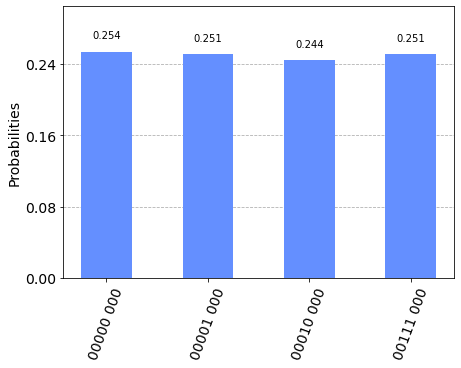

In [134]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import BasicAer
from qiskit import execute
from qiskit.visualization import plot_state_qsphere
# Import math Library
import math 
###############################################################
# Set the backend name and coupling map.
###############################################################
backend = BasicAer.get_backend("qasm_simulator")


###############################################################
# Make a quantum program for the n-bit ripple adder.
###############################################################
number_of_digits = 3
number_of_qubits = 2;

q = QuantumRegister(number_of_qubits, "q")
a = QuantumRegister(number_of_digits, "a")
b = QuantumRegister(number_of_digits, "b")
cin  = QuantumRegister(1, "cin")
cout = QuantumRegister(1, "cout")

threshold = ClassicalRegister(number_of_digits, "threshold")
ans = ClassicalRegister(number_of_digits + 2, "ans")
qc = QuantumCircuit(q, a, b, cin, cout,threshold, ans, name="quantum_controlled_Adder")

def vGate( p, a, b):
    """VGate gate."""
    p.h(b)
    p.cu1(math.pi/2, a, b)
    p.h(b)
    
def vPGate( p, a, b):
    """VGate gate."""
    p.h(b)
    p.cu1(-math.pi/2,a, b)
    p.h(b) 

def PeresGate(p, a, b, c):
    vPGate( p, a, c)
    vPGate( p, b, c)
    p.cx(a,b)
    vPGate( p, b, c)

def ToffoliGate(p, a, b, c):
    vGate(p, a, c)
    p.cx(b, a)
    vGate(p, b, c)
    vPGate(p, a, c)
    p.cx(b, a)
    
def majority(p, a, b, c):
    """Majority gate."""
    p.cx(c, b)
    p.cx(c, a)
    p.ccx(a, b, c)


def unmajority(p, a, b, c):
    """Unmajority gate."""
    p.ccx(a, b, c)
    p.cx(c, a)
    p.cx(a, b)    

# This method compares input a with b and returns the result in cout
# if a>=b cout is 0, if a<b cout is 1
# arguments:
# p: quantum circuit
# a: first input register to compare
# b: second input register to compare
# cin: 1 qubit register for algorithm uses
# cout: returns the result, 1 if a<b, zero otherwise
def comparator (p,a,b,cin,cout,l):
    # invert a to form (a'+b)'
    for j in range(l):
        p.x(a[j])

    majority(p, cin[0], b[0], a[0])
    for j in range(l - 1):
        majority(p, a[j], b[j + 1], a[j + 1])
    p.cx(a[l - 1], cout[0])
    for j in reversed(range(l - 1)):
        unmajority(p, a[j], b[j + 1], a[j + 1])
    unmajority(p, cin[0], b[0], a[0])
    
# This method sets the value of register bit by bit
# arguments
# p: quantum circuit
# b: quantum register to hold the value
# v : classical register which holds the value to store
# l : length of qubit b
def setValueToRegister (p,b,v,l):
    for j in range(l):
        p.reset(b[j])
        if ((v & (1<<j)) != 0):
            p.x(b[j])           

# This method adds the given value to the current value in register c in control of qubit a
# if a equls 1 b is added to c otherwise no changes in c
# arguments:
# p is circuit
# a is the control qubit length 1
# b is the value holding qubit, length l
# c is the qubit to hold the, length l
# v is the value to be converted to binary and added
# l is the length of qubits b and c 
def addToTotal (p,a,b,c,v,l):
    # reset the temporary value holding register b
    for j in range(l):
        p.reset(b[j])
        if ((v & (1<<j)) != 0):
            p.x(b[j])    
        ToffoliGate(p, a, b[j], c[j])
            

# Set the inputs to the adder
# superposition of the xi
qc.h(q[0])
qc.h(q[1])

# register a holds the total fitness value
# register b holds the temporary candidate fitness value
# simple circuit for x1 + 2x2

# load 1 for fintess value of x1

addToTotal(qc, q[0],b,a,1,3)
# load 2 for the fitness value of x2
addToTotal(qc, q[1],b,a,2,3)

# Set threshold value to 2
setValueToRegister(qc, b, 2, 3)

#qc.measure(q[0],ans[0])
#qc.measure(q[1],ans[1])
#qc.measure(a[0],ans[2])
#qc.measure(a[1],ans[3])
#qc.measure(a[2],ans[4])


comparator(qc,b,a,cin,cout,3)



qc.measure(q[0],ans[0])
qc.measure(q[1],ans[1])
qc.measure(cout,ans[2])


job = execute(qc, backend=backend, coupling_map=None, shots=1024)
result = job.result()
counts  = result.get_counts(qc)
print(counts)
plot_histogram(counts)
